### Create AlexNet in keras <br>
In this notebook we will create AlexNet using keras and train that on cifar10 for classification of images. <br>
First let's look at the architecture of AlexNet and then we will use the primitive layers provided by keras to build our model.

#### AlexNet <br>
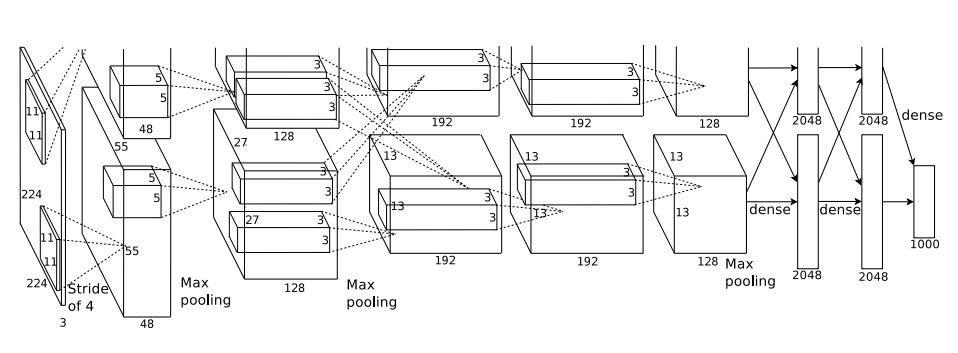

AlexNet is a 8-layered CNN which won the 2012 ImageNet Large Scale Visual Recognition Challenge (ILSVRC). The simplified architecture with layer details is shown below (bottom-most is the input layer and top layer is the final layer): <br>

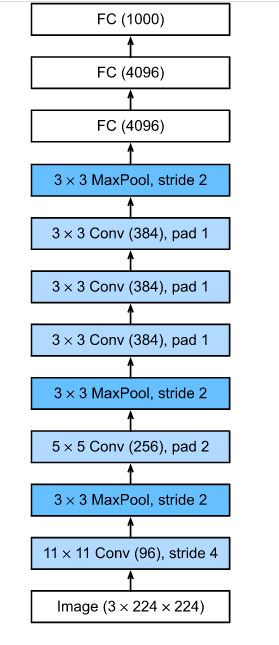

In the figures above, we have seen that the model takes input shape of 224x224x3 and the last FC layer has 1000 neurons because ImageNet has 1000 classes. But for our purpose, since we are using cifar10, the following changes will be made: <br>
* number of neurons in the final FC layer will be 10 because cifar10 has 10 classes <br>

* since the image size of cifar10 are 32x32x3 we will make the input shape of network to be 32x32x3. <br>

* We will use `padding='same'` in convolution as well as pooling layers so that the spatial resolution does not decrease.The resolution of images is already small so downsampling will make further operations difficult. For example if our feature map's spatial dimension reduces to 1x1, we will not be able to apply 3x3 Conv filter without preprocessing/upsampling. However downsampling is performed on some layers by striding.

Let's create AlexNet model now using keras.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten

In [ ]:
alexnet = Sequential()

In [ ]:
# add 96 convolution filters of size 11x11 with stride 4
alexnet.add(Conv2D(96, (11, 11), strides=(4,4), padding='same', activation='relu', input_shape=(32, 32, 3)))
alexnet.add(MaxPooling2D((3,3), strides=(2,2), padding='same'))

alexnet.add(Conv2D(256, (5,5), padding='same', activation='relu'))
alexnet.add(MaxPooling2D((3,3), strides=(2,2), padding='same'))

alexnet.add(Conv2D(384, (3,3), padding='same', activation='relu'))
alexnet.add(Conv2D(384, (3,3), padding='same', activation='relu'))
alexnet.add(Conv2D(384, (3,3), padding='same', activation='relu'))
alexnet.add(MaxPooling2D((3,3), strides=(2,2), padding='same'))

# flatten the input feature map. here it flattens the last feature map before it
alexnet.add(Flatten())

# add FC layers. Using less no. of neurons here
alexnet.add(Dense(384, activation='relu'))
alexnet.add(Dense(384, activation='relu'))

# add FC layer with 10 units for we have 10 classes
# use softmax activation for classification
alexnet.add(Dense(10, activation='softmax'))

In [ ]:
alexnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 96)          34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 384)         1

Load data:

In [ ]:
from keras.datasets import cifar10

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
# normalize the pixel values
import numpy as np

X_train = np.array(X_train, dtype='float') / 255.0
X_test = np.array(X_test, dtype='float') / 255.0

In [ ]:
# one hot encoding labels
from keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

Compile the model:

In [ ]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
alexnet.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Train the model:

In [ ]:
H = alexnet.fit(X_train, y_train_ohe, batch_size=128, epochs=50, verbose=1, validation_split=0.15)

Epoch 1/50
333/333 [==============================] - 749s 2s/step - loss: 2.2998 - accuracy: 0.1397 - val_loss: 2.2975 - val_accuracy: 0.1709
Epoch 2/50
333/333 [==============================] - 747s 2s/step - loss: 2.2925 - accuracy: 0.2049 - val_loss: 2.2831 - val_accuracy: 0.2137
Epoch 3/50
333/333 [==============================] - 751s 2s/step - loss: 2.2492 - accuracy: 0.1996 - val_loss: 2.1707 - val_accuracy: 0.1891
Epoch 4/50
333/333 [==============================] - 767s 2s/step - loss: 2.0679 - accuracy: 0.2188 - val_loss: 2.0449 - val_accuracy: 0.2187
Epoch 5/50
333/333 [==============================] - 738s 2s/step - loss: 1.9629 - accuracy: 0.2576 - val_loss: 1.9109 - val_accuracy: 0.2745
Epoch 6/50
333/333 [==============================] - 736s 2s/step - loss: 1.8666 - accuracy: 0.2909 - val_loss: 1.8027 - val_accuracy: 0.3167
Epoch 7/50
333/333 [==============================] - 735s 2s/step - loss: 1.7913 - accuracy: 0.3236 - val_loss: 1.7705 - val_accuracy: 0.3316

In [ ]:
# save the trained weights on disk
alexnet.save_weights('alexnet_trained_cifar10.h5')

Learning curve:


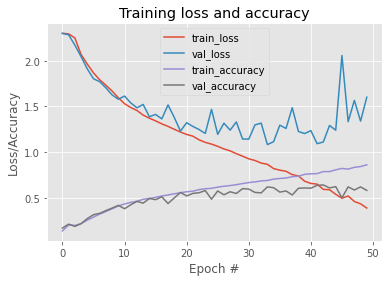

In [ ]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

Evaluate:

In [ ]:
# load pretrained model weights from disk
alexnet.load_weights('alexnet_trained_cifar10.h5')

In [ ]:
score = alexnet.evaluate(X_test, y_test_ohe, batch_size=32)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

313/313 [==============================] - 11s 34ms/step - loss: 1.6282 - accuracy: 0.5774
Test Loss =  1.628174066543579
Test Accuracy =  0.5774000287055969


In [ ]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = alexnet.predict_classes(X_test)
y_true = np.argmax(y_test_ohe, axis=1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
confusion_mtx

array([[780,   4, 128,   6,  10,   2,   1,  18,  32,  19],
       [ 95, 619,  31,  10,   6,   4,   3,  20,  33, 179],
       [ 83,   1, 758,  24,  47,  20,   6,  47,   5,   9],
       [ 45,   4, 305, 276,  83, 141,  20,  97,   8,  21],
       [ 41,   2, 292,  19, 469,  14,  10, 143,   8,   2],
       [ 14,   3, 291,  99,  51, 370,   6, 157,   5,   4],
       [ 12,   3, 356,  62, 114,  32, 375,  28,   8,  10],
       [ 25,   1, 105,  15,  45,  23,   2, 776,   0,   8],
       [166,  30,  51,  13,  21,   5,   1,   7, 680,  26],
       [ 89,  59,  44,  15,   8,   8,   1,  74,  31, 671]])

We can view this confusion matrix as a heatmap of color encoded matrix using `seaborn` library. We can print the labels on both axes and color code the no. of correct predictions, as shown below:

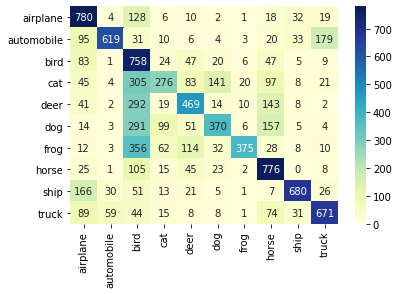

In [ ]:
import seaborn as sns
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='d', cmap="YlGnBu")